# TP5: Image segmentation

In this practical sessions, we will try out basic techniques for *segmenting* images (finding parts of the images that have similar content). We will be exploring two families of method, *clustering methods* that seek a fixed number of sets (clusters) of similar pixels in the image, and *watershed methods*.

## Part A : Clustering methods (feature-based segmentation)

In the following, we will segment the image by defining clusters of pixels that share similar features: this is thus called feature-based segmentation. Of course, clustering is not a problem that is limited to image processing, and the methods that we will cover in this section are fairly general. To reflect this, we will work from now on with a *set* $X$ of $N$ vectors $x_i$ living in dimension $d$ (in image segmentation, each $x_i$ represents one pixel, living in dimension $d = 3$ for RGB images),

$$ X = \{x_i \in \mathbb R^d \: | \: i = 1,...,N\}.$$


In order to find clusters in $X$, we need to decide how we will mathematically characterize those clusters. As we will see, different parameterizations of the clusters will lead to different clustering algorithms.  

## 1] K-Means clustering (Lloyd-Max)
In K-means clustering, the clusters are defined by their centers $c_k$, called centroids. The problem of K-means clustering can be formulated as follows:

$$c_1^*,...c_K^* = \arg \min_{c_1,...c_K} \sum_{i = 1}^N \min_{1 \leq k \leq K} \|x_i - c_k\|_2^2.$$

This problem is not trivial to solve (in fact, it is NP-hard), but one heuristic to approximate a solution is the k-means *algorithm* (a somewhat confusing name).

Since this algorithm is fairly easy to implement, we will write it ourselves as a warm-up for this session (although you should know numerous implemetations are available online, e.g. from the `sklearn` library for machine learning). First, let us define some data to test our method on.

In [36]:
import numpy as np
import matplotlib.pyplot as plt

Generated dataset in dimension 2:


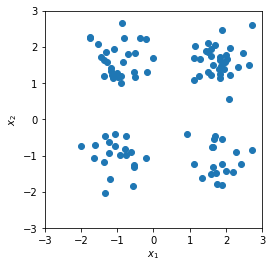

In [2]:
## GIVEN: generate a simple 2-d dataset to test our method
N = 100
dim = 2
X = 0.45*np.random.randn(N,dim) + 2.75*np.random.randint(2,size=(N,dim))-1
print('Generated dataset in dimension 2:')
# Visualize the dataset
plt.scatter(X[:,0],X[:,1])
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()


## GIVEN: a number of centroids to test the method (we assumed this is known)
K = 4

In [3]:
## TO RUN
# GIVEN: a visualization tool for our centroids
from TP5_utils import plotTheCentroids

# Defined as
#
# def plotTheCentroids(X,assignments,centroids,iteration = None,plotCentroids=True):
#    """Plots a data in 2-D with the associated centroids.
#    
#    Argument:
#    - X: numpy array, the dataset
#    - assignments: numpy array of ints, the assignments to clusters of the elements of X
#    - centroids: numpy array, the centroids
#    - iteration: int, the kmeans iteration at which the plot function is called
#    """

The K-means algorithm alternates between two steps: 

* **Step 1** given some centroids, find the best assignment of the data samples 
* **Step 2** given some assignment of the data samples, find the best centroids. 

Let's take it slow and write each step separately.

## 1.a] Step 1
Write code that assigns the examples in $X$ to some cluster index given the centroids. More precisely, you need to fill the `assignments` array such that the $i$-th entry of this array $a$ satisfies

$$ a_i = \arg\min_{k} \| x_i - c_k \|_2^2.$$

CPU times: user 122 ms, sys: 0 ns, total: 122 ms
Wall time: 120 ms


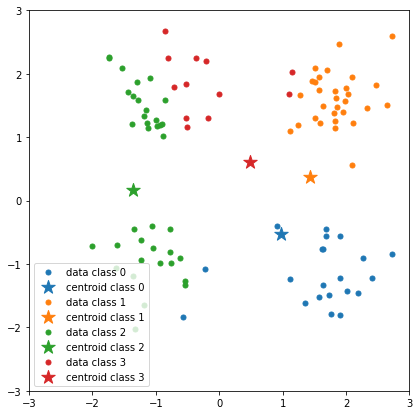

In [4]:
%%time
centroids = np.random.randn(K,dim) # Random centroids, supposed given

assignments = np.zeros(N)

for i in range(N):
    diff = np.broadcast_to(X[i], (K,dim)) - centroids
    l2_norm = np.linalg.norm(diff, ord=2, axis=-1)
    l2_norm_squared = np.power(l2_norm, 2)
    argmin = np.argmin(l2_norm_squared, axis=0)
    assignments[i] = argmin

# Plot the centroids of the clusters (given)
plotTheCentroids(X,assignments,centroids)

In [5]:
def distance_from_centroids(points, centroids):
    diff = points[:, np.newaxis] - centroids # shape : N, K, dim
    distances = np.sqrt(np.power(diff, 2).sum(axis=-1)) # shape : N, K
    return distances

def closest_centroid(points, centroids):
    distances = distance_from_centroids(points, centroids)
    return np.argmin(distances, axis=-1) # shape : N

**Question:** Are you able to identify the zones where the assignments jump from one centroid to another? What do these zones look like?





In [6]:
# Your discussion here

## 1.b] Step 2
Now, we assume that the assignments are fixed: write code to assign the best centroids given the assignments:

$$ c_k = \arg\min_{c} \sum_{i \text{ s.t. } a_i = k } \| x_i - c \|_2^2.$$


Notice we kindly predefined good assignments for you!

*Hint* : Maybe do you know in advance what is the trivial solution to this problem?

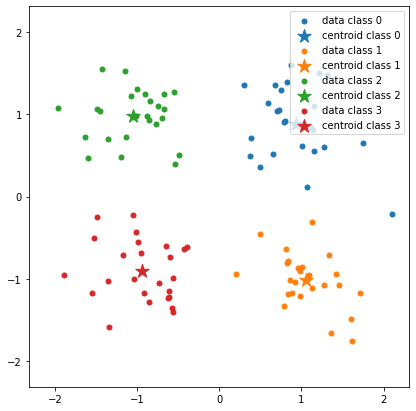

In [7]:
Xtest = np.zeros((N,dim))
assignments = np.zeros(N)

width = N//K
for i in np.arange(K):
    start = i*width
    stop = (i+1)*width
    Xtest[start:stop,:] = [(-1)**(i//2), (-1)**(i%2)] + 0.4*np.random.randn(width,dim)
    assignments[start:stop] = i

centroids = np.zeros([K,dim]) 

for k in range(K):
    centroids[k] = np.mean(Xtest[k == assignments], axis=0)

# Plot the centroids of the clusters (given)
plotTheCentroids(Xtest,assignments,centroids)

In [8]:
def find_best_coordinates_for_centroids(points, assignements, centroids):
    K = len(centroids)
    new_centroids = np.zeros_like(centroids)
    for k in range(K):
        k_points = points[assignements == k]
        new_centroids[k] = np.mean(k_points, axis=0) if len(k_points) > 0 else np.zeros_like(points[-1]) 
    
    return new_centroids

## 1.c] Synthesis

Now, put those steps together to form the k-means algorithm.

In [9]:
def kmeans(X, K, initype = 'random', maxIter = 100, tol=1e-5, plotIterations = False):
    """Some example here for good practice"""
    (N,dim) = X.shape
    
    """ Switch intialization. Don't forget to reset N,X and K by running the upper cell """
    if (initype=='random'):
        centroids = np.random.randn(K,dim) # Random init
    elif (initype=='kmeans_pp'):
        centroids = kmeans_pp_init(X,K) 
    assignments = np.zeros(N)
    
    for iterate in range(maxIter):
        cache_centroids = centroids.copy()
        assignments = closest_centroid(X, centroids)
        centroids = find_best_coordinates_for_centroids(X, assignments, centroids)
        
        if plotIterations:
            plotTheCentroids(X, assignments, centroids, iteration=iterate, plotCentroids=True)
        
        if np.linalg.norm(centroids - cache_centroids) < tol:
            break
        
    print('K-means terminated after {} iterations'.format(iterate+1))
            
    return centroids, assignments

In [10]:
# TO RUN
(c,assignments) = kmeans(X,K)

K-means terminated after 3 iterations


## 2] Application

Let's try our clustering algorithm to segment an RGB image! Run the cells below...

Test image that we will segment:


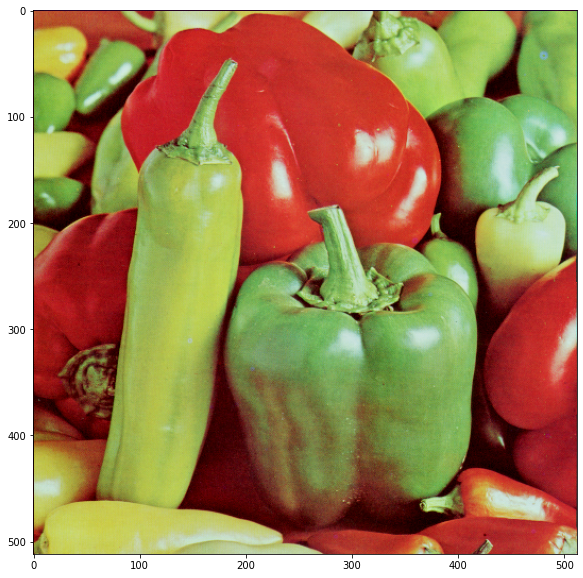

In [11]:
# TO RUN
import imageio
# Load the image
imfile = imageio.imread('images/peppers.png')
image = np.array(imfile)/255 # Normalize between 0 and 1

# Reshape the image as a list of pixels
X = image.reshape((image.shape[0]*image.shape[1],3))

# Plot the image
print('Test image that we will segment:')
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.show()

In [12]:
# TO RUN

%matplotlib notebook 

# Visualize the pixels in the RBG space
subsampling = 8 # don't plot ALL the pixels so we can see the shape better (if =1 plot all)

print('Cloud point of the pixels in the RGB place (1/{} of the pixels shown):'.format(subsampling))

from mpl_toolkits.mplot3d import Axes3D # Needed for 3D plots

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')
Xs = X[::subsampling]
ax.scatter(Xs[:,0],Xs[:,1],Xs[:,2], marker='o',s=0.2, c = Xs)
ax.set_xlabel('R')
ax.set_ylabel('G')
ax.set_zlabel('B')
plt.show()

Cloud point of the pixels in the RGB place (1/8 of the pixels shown):


<IPython.core.display.Javascript object>

## 2.a] Features in the RGB space

Now, run the K-means clustering! Try out different values for $K$ and observe the result of the segmentation.

In [13]:
# TO RUN
# with different values of K
K = 5
maxIter = 20 # Careful, increasing this might make the algorithm slow
(centroids,assignments) = kmeans(X,K,initype='random',maxIter = maxIter,plotIterations = False)
print(centroids)

K-means terminated after 20 iterations
[[0.68371656 0.77751045 0.44372081]
 [0.59711329 0.         0.72230781]
 [0.72458991 0.19022292 0.15642032]
 [0.47644328 0.57880467 0.27382309]
 [0.3078846  0.05851988 0.0450363 ]]


In [14]:
# TO RUN

# Visualize the centroids in the RGB space
fig = plt.figure(figsize=(7,7))

ax = fig.add_subplot(111, projection='3d')
Xs = X[::subsampling]
ax.scatter(Xs[:,0],Xs[:,1],Xs[:,2], marker='o',s=0.5, alpha = 0.05)
ax.scatter(centroids[:,0],centroids[:,1],centroids[:,2], marker='*',s=350, alpha=1,c = centroids)
plt.legend(['data','centroids'])
ax.set_xlabel('R')
ax.set_ylabel('G')
ax.set_zlabel('B')

plt.show()

<IPython.core.display.Javascript object>

In [15]:
%matplotlib inline

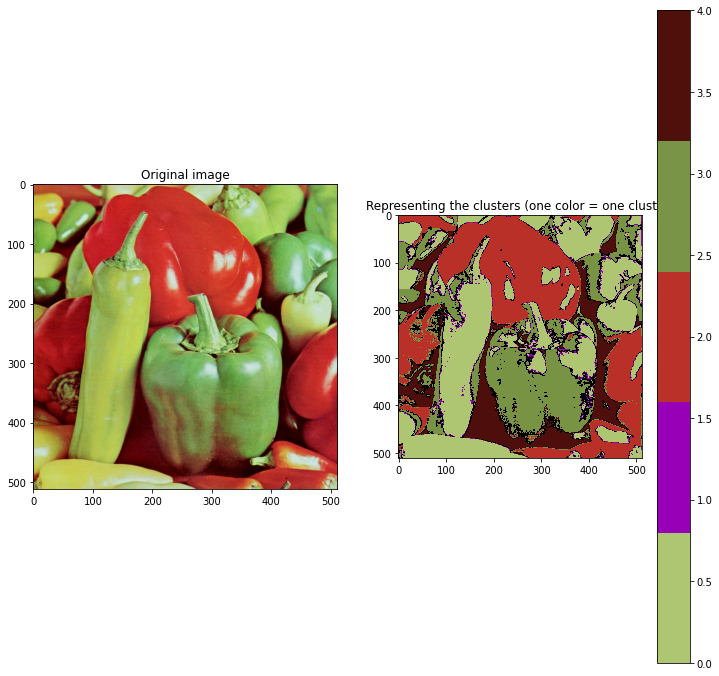

In [16]:
# TO RUN

# Visualize the clusters in the image domain
from TP5_utils import visualizeSegmentation
visualizeSegmentation(image,centroids,assignments)

## 2.b] Adding more features for the segmentation

We have clustered the images pixels according to the RGB features of each pixel. According to what is desired, other features can also be used. For example, if we want to have more localized clusters (you might have noticed that the previous clusters tend to be scattered on the whole image), the positions of the pixels can be used as additional features. Together with the RGB information, we thus have $d=5$ dimensional features.

Run k-means on the pixels of the images, for which we also add the position as feature. That is, each pixel $i$ is characterized by the features

$$ x_i^T = [r_i,g_i,b_i,p_i,q_i], $$

where $r_i,g_i,b_i$ is the RGB information of that pixel, and $p_i,q_i$ are itq spatial coordinates in the image (where we suppose the spatial domain of the image is $[0,1]^2$, i.e. **all the features are normalized** such that $0\leq r_i,g_i,b_i, p_i, q_i \leq 1$). We denote $X_p$ this new dataset that includes the position.

In [17]:
# TO COMPLETE

X_p = np.zeros((image.shape[0]*image.shape[1],5)) # 5-dimensional features

H, W, C = image.shape
rgb_dist = image.reshape((-1, C))
p_dist = np.linspace(0, 1, H)
q_dist = np.linspace(0, 1, W)

X_p[:,:C]  = rgb_dist
X_p[:,C]   = np.repeat(p_dist, W)
X_p[:,C+1] = np.tile(q_dist, H)

print('First few elements of X_p:')
print(X_p[:5])
print('Last few elements of X_p:')
print(X_p[-5:])

First few elements of X_p:
[[0.39607843 0.         0.         0.         0.        ]
 [0.54901961 0.         0.55686275 0.         0.00195695]
 [0.59215686 0.         0.57254902 0.         0.00391389]
 [0.62745098 0.         0.54509804 0.         0.00587084]
 [0.63137255 0.         0.58039216 0.         0.00782779]]
Last few elements of X_p:
[[0.66666667 0.8        0.63529412 1.         0.99217221]
 [0.67058824 0.8        0.6        1.         0.99412916]
 [0.65098039 0.78039216 0.58823529 1.         0.99608611]
 [0.67058824 0.80392157 0.70980392 1.         0.99804305]
 [0.77647059 0.78431373 0.67058824 1.         1.        ]]


Run the code below to run k-means on this "augmented" dataset. Just so you can test the influence of adding the position, we added a parameter "importanceOfPosition" that you can change to see what happpens (1 means position is "as important as color", close to 0 means position doesn't matter, much larger than 1 means color doesn't matter).

In [18]:
# TO RUN
importanceOfPosition = 1.1 # Play with this
K = 5 # And also with this
X_p_w = X_p.copy()
X_p_w[:,-2:] *= importanceOfPosition

(centroids2,assignments2) = kmeans(X_p_w,K,initype='random',maxIter = maxIter,plotIterations = False)

K-means terminated after 20 iterations


In [19]:
# TO RUN
from TP5_utils import compareSegmentations

from ipywidgets import widgets, interact
Ks = widgets.IntSlider(min=1, max=20, step=1, value=5)
importances = widgets.FloatSlider(min=0, max=5, step=.01, value=1.)
maxiters = widgets.IntSlider(min=1, max=20, step=1, value=10)
@interact(K=Ks, importanceOfPosition=importances, maxIter=maxiters)
def _(K, importanceOfPosition, maxIter):
    X_p_w = X_p.copy()
    X_p_w[:,-2:] *= importanceOfPosition

    (centroids2,assignments2) = kmeans(X_p_w,K,initype='random',maxIter = maxIter,plotIterations = False)
    compareSegmentations(image,centroids,assignments, centroids2, assignments2)

interactive(children=(IntSlider(value=5, description='K', max=20, min=1), FloatSlider(value=1.0, description='…

**Question:** Which qualitatives differences do you observe between the two segmentations? What is your intuition about it?

In [20]:
# Your discussion here

## 3] Kmeans++ initialization

As you have probably seen during the class and also noticed here above, the random initialization used previously is far from optimal.
It can be easily understood observing that some centroids that are unluckily initialized in an empty zone in the feature space get "abandoned" by the kmean algorithm. 

The k-means++ initialization tries to avoid these drawbacks. The algorithm is reminded here :

<img src="images/kmeans++.PNG" alt="kmeans++ algorithm" width="500"/>

### Important 

Once having written the algorithm, you can come back to the toy example in **1)** and modify the *initype* input of the kmeans function. This should help you visually confirm that kmeans++ is working well!

In [21]:
# TO COMPLETE : write the code implementing the kmeans++ initialization algorithm
def kmeans_pp_init(X, K):
    """
        Based on : https://www.analyticsvidhya.com/blog/2019/08/comprehensive-guide-k-means-clustering/
    """
    N, dim = X.shape
    centroids = np.zeros((K, dim))
    
    indexes = np.arange(N, dtype=np.int)
    centroid_indexes = np.zeros_like(indexes)
    
    chosen_index = np.random.choice(indexes) # Get first centroid (random uniform choice)
    centroids[0] = X[chosen_index]
    
    for k in range(1, K):
        # Get distances between all data points and already chosen centroids
        distances = distance_from_centroids(X, centroids[:k]) # N, K
        
        # Get distances between all data points and its closest centroid
        distances_to_closest_centroid = np.min(distances, axis=-1) # N
        
        # Squared the distance
        distances_to_closest_centroid_squared = np.power(distances_to_closest_centroid, 2) # N
        p = distances_to_closest_centroid_squared / sum(distances_to_closest_centroid_squared)
        
        # Get the next centroid
        chosen_index = np.random.choice(indexes, p=p)
        centroids[k] = X[chosen_index]
        
    return centroids

## 4] Spectral clustering
Now, K-means clustering is nice because it is fairly simple, but it is not suited to complicated (e.g., nonconvex) cluster shapes. We will now implement the spectral clustering algorithm that is able to tackle this problem (though we won't use it on our test image, as it is a little bit tricky to implement a fast implementation of it without entering into the subtleties of working with sparse matrix representations, which is a lot to cover in 2 hours).

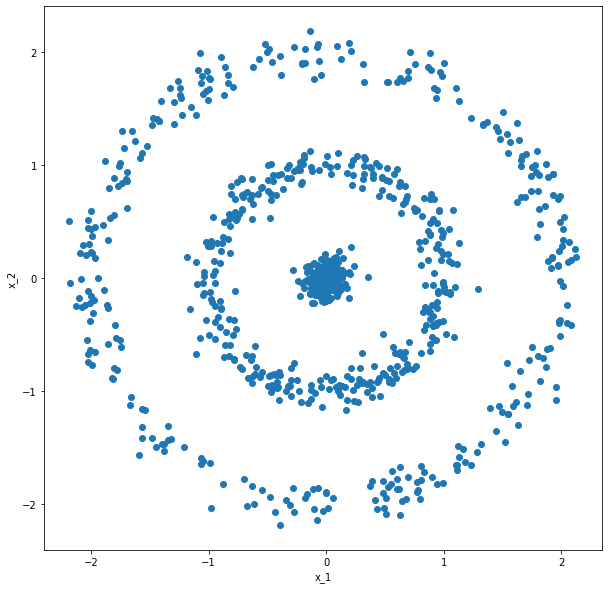

In [22]:
# TO RUN

# Let's build a simple dataset where K-means doesn't get the job done
N = 1000
dim = 2
Nring = 3
thetas = np.random.uniform(0,2*np.pi,N)
# Toy example dataset to test vanilla k-means VS spectral clustering

X = ((np.array([np.cos(thetas),np.sin(thetas)]))*(np.random.randint(Nring,size=N)+0.1*np.random.randn(N))).T

plt.figure(figsize=(10,10))
plt.scatter(X[:,0],X[:,1])
plt.xlabel('x_1')
plt.ylabel('x_2')
plt.show()

## 4.a] Kmeans : the fall of the data space empire

K-means terminated after 5 iterations


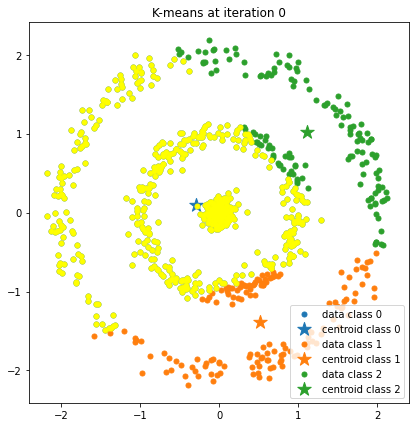

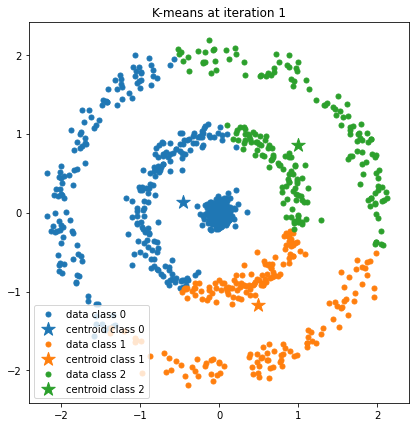

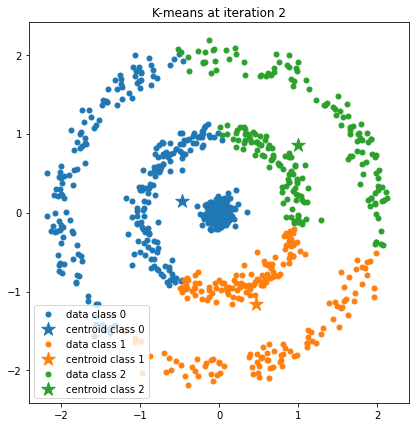

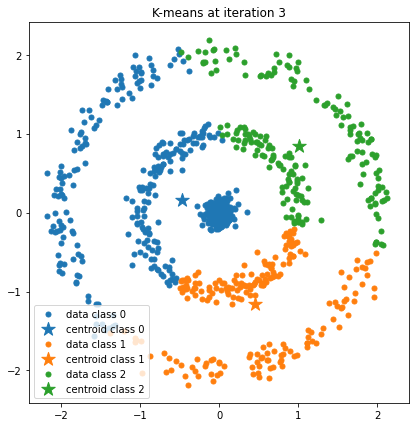

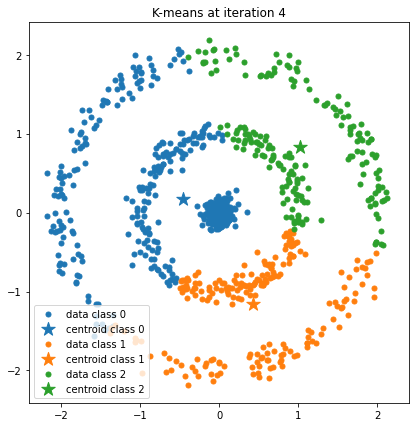

In [23]:
# TO COMPLETE: run kmeans (with K adequatly chosen) on the dataset above and plot it (e.g. using )
# What do you observe?

K = 3# Choose an appropriate value for K
centroids, assignments = kmeans(X, K, initype = 'kmeans_pp', maxIter = 5, plotIterations = True)


## 4.b] Rescued by graphs theory and spectral clustering

The idea of spectral clustering is to build a graph (represented as an adjacency matrix $W \in \mathbb R^{N \times N}$) where the nodes are the pixels and the weigthed edges represent the "similarities" between them. For now, we do the simple choice of computing the similarities as (you might have seen this formula before :-P)

$$W_{i,j} = \exp(- \frac{ \|x_i - x_j\|_2^2}{2 \sigma^2})$$.

The next step is to build the graph Laplacian $L$ defined as :

$$ L = D - W $$

where $D$ is the degree matrix, a diagonal matrix with $D_{i,i} = \sum_j W_{i,j}$.

Then, we cluster the data in the eigendecomposition of this laplacian matrix $L$ (hence the name "spectral"). This is motivated by the fact that points that are on the same connected component of the graph will have the same eigenvalue (see the course for mor information).

Showing some entries of W


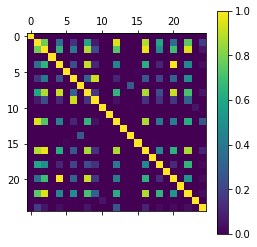

In [24]:
## TO COMPLETE : compute the adjacency matrix W (weights) associated with the dataset X the pixels + graph Laplacian

sigma = 0.1 # Given... for now :-)
N, dim = X.shape

diff = X[:,np.newaxis] - X
norm = np.square(np.linalg.norm(diff, axis=-1))
W = np.exp(- norm / (2* sigma**2))

print('Showing some entries of W')
plt.matshow(W[:25,:25])
plt.colorbar()
plt.show()

Showing some entries of L


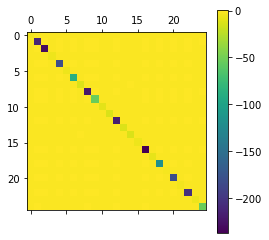

In [25]:
## TO COMPLETE : compute the graph Laplacian

D = np.diag(np.sum(W, axis=1))
L = W - D


print('Showing some entries of L')
plt.matshow(L[:25,:25])
plt.colorbar()
plt.show()

If the graph Laplacian is correctly computed, the following code should map the dataset $X$ to another dataset $U$ in the frequency domain of the graph. $U$ contains the first $K$ eigenvectors of the graph Laplacian. Run the code below to observe this "transformed dataset".

Showing the 10 lowest eigenvalues' orders of magnitude :
-26
-16
-13
-7
-6
-5
-5
-4
-4
-4


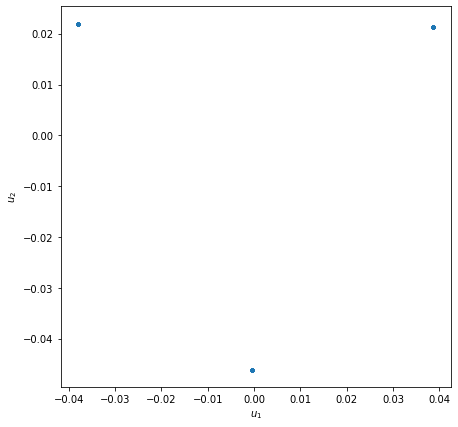

In [26]:
# TO RUN
import math
def orderOfMagnitude(number):
    return math.floor(math.log(number, 10))

# SVD decomposition of L
(U,s,_) = np.linalg.svd(L, full_matrices=True)

eigenvalues = s**2
print('Showing the 10 lowest eigenvalues\' orders of magnitude :')
for i in np.arange(10) :
    print(orderOfMagnitude(eigenvalues[-i-1]))

# Keep only K first eigenvectors
# Careful: SVD returns the singular values in DESCENDING order; we thus want to extract the LAST two columns
U = U[:,-K:]

# Plot the "transformed dataset"
plt.figure(figsize=(7,7))
plt.scatter(U[:,0],U[:,1],s=5)
plt.xlabel('$u_1$')
plt.ylabel('$u_2$')
plt.show()

**Question:** Can you make a link between the obtained eigenvalues' orders of magnitude and the number of clusters appearing in the upper figure? Does this validate your previous choice of K?

In [27]:
# Your discussion here

Time to perform the spectral clustering! SImply call k-means on $U$ below to obtain the assignments given by spectral k-means.

K-means terminated after 1 iterations
Plot clusters the spectral domain
Plot clusters the initial domain


Text(42.290000000000006, 0.5, '$x_2$')

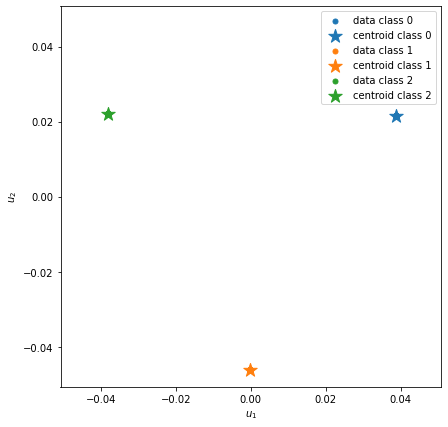

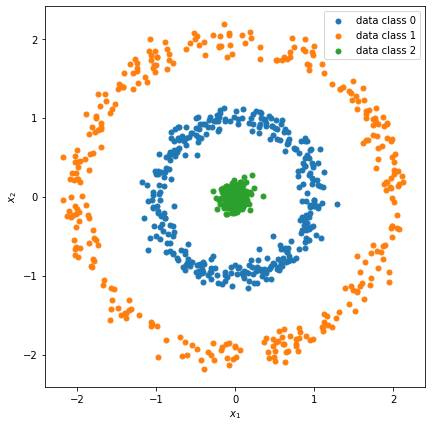

In [28]:
# TO RUN: k-means in spectral domain
(centroids_u,assignments) = kmeans(U,K,initype='kmeans_pp',plotIterations=False)

# Plot in the spectral domain
print('Plot clusters the spectral domain')
plotTheCentroids(U,assignments,centroids_u,iteration = None,plotCentroids=True)
plt.xlabel('$u_1$')
plt.ylabel('$u_2$')
# and in the initial domain
print('Plot clusters the initial domain')
plotTheCentroids(X,assignments,centroids_u,iteration = None,plotCentroids=False)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')

In [29]:
def spectral_kmeans(X, K, sigma=.1, initype='kmeans_pp', plotIterations=False):
    """
        Compute the Kmeans algorithm in the spectral domain
    """
    N, dim = X.shape

    diff = X[:,np.newaxis] - X
    norm = np.linalg.norm(diff, axis=-1)
    W = np.exp(- np.square(norm) / (2* sigma**2))

    D = np.diag(np.sum(W, axis=1))
    L = W - D   

    (U,s,_) = np.linalg.svd(L, full_matrices=True)

    U = U[:,-K:]

    (centroids_u,assignments) = kmeans(U,K,initype=initype,plotIterations=plotIterations)

    return centroids_u, assignments

K-means terminated after 16 iterations
K-means terminated after 2 iterations


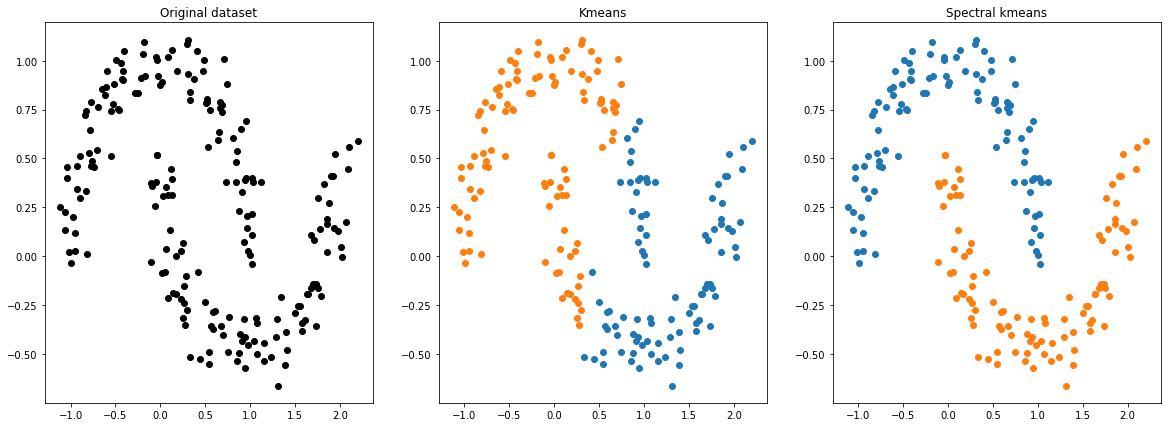

In [30]:
from sklearn.datasets import make_moons, make_blobs

def spectral_and_not_kmeans(X, K, sigma=.1, initype='kmeans_pp', plot=False):
    N, dim = X.shape

    diff = X[:,np.newaxis] - X
    norm = np.square(np.linalg.norm(diff, axis=-1))
    W = np.exp(- norm / (2* sigma**2))

    D = np.diag(np.sum(W, axis=1))
    L = W - D

    w, v = np.linalg.eig(L)
    K_smallest_indexes = np.argpartition(w, -K)[-K:]
    U = v[:, K_smallest_indexes]

    x_centroids, x_assignments = kmeans(X, K, initype=initype, plotIterations=False)
    u_centroids, u_assignments = kmeans(U, K, initype=initype, plotIterations=False)

    if plot:
        fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(20,7))
        ax1.scatter(X[:,0], X[:,1], color='black')
        ax1.set_title("Original dataset")

        ax2.set_title("Kmeans")
        for label in np.unique(x_assignments):
            ax2.scatter(X[x_assignments==label, 0], X[x_assignments==label, 1])

        ax3.set_title("Spectral kmeans")
        for label in np.unique(x_assignments):
            ax3.scatter(X[u_assignments==label, 0], X[u_assignments==label, 1])

        _=plt.plot()


X, y = make_moons(200, noise=.1)
spectral_and_not_kmeans(X, 2, plot=True)

**Question:** Is it working as expected? 
If yes, check it a couple times before confirming :) 
If not, do you have any clue about what could go wrong? 

In [31]:
# Your discussion here

**Question:** Did we really build a K-groups graph like the following here?

<img src="images/K_groups_graph.PNG" alt="K groups graph" width="400"/>

In [32]:
# Your discussion here

### Bonus exercise : Another way to build the graph
* (easy): try out other definitions for the weigths W that yield a sparse matrix L.
  For example, $W_{i,j} = \begin{cases} W_{i,j}, & \mbox{if } |x_i-x_j| < threshold \\ 0, & \mbox{otherwise } \end{cases} $ 
  
* (Advanced) : implement the computation of the matrix U such from a sparse representation of L
  (e.g., using https://docs.scipy.org/doc/scipy/reference/sparse.html and     https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.eigsh.html#scipy.sparse.linalg.eigsh)
  such that you can use it to segment large-scale images

K-means terminated after 2 iterations


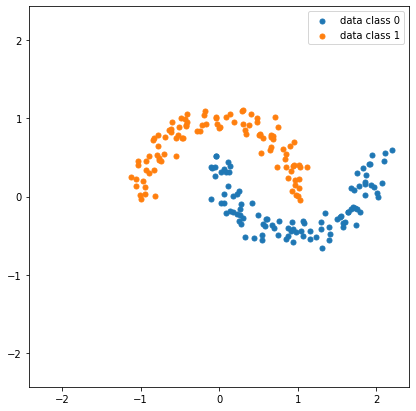

In [42]:
def thresh_spectral_kmeans(X, K, threshold, sigma=.1):
    N, dim = X.shape

    diff = X[:,np.newaxis] - X
    norm = np.linalg.norm(diff, axis=-1)
    norm[norm >= threshold] = .0
    W = np.exp(- np.square(norm) / (2* sigma**2))

    D = np.diag(np.sum(W, axis=1))
    L = W - D   

    (U,s,_) = np.linalg.svd(L, full_matrices=True)

    U = U[:,-K:]

    (centroids_u,assignments) = kmeans(U,K,initype='kmeans_pp',plotIterations=False)

    return centroids_u, assignments


centroids_u_thresh, assignments_thresh = thresh_spectral_kmeans(X, 2, threshold=10)

plotTheCentroids(X,assignments_thresh,centroids_u_thresh,iteration = None,plotCentroids=False)

## Part B : Bonus: Watershed methods
Try to implement watershed segmentation on our pepper test image. For this more advanced algorithm, use an available implementation, e.g. one of those
* https://scikit-image.org/docs/dev/auto_examples/segmentation/plot_watershed.html
* https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_watershed/py_watershed.html

In [37]:
from scipy import ndimage
from skimage.segmentation import watershed
from skimage.feature import peak_local_max